In [2]:
import numpy as np
import pandas as pd
import cv2
from glob import glob
import os
import pathlib

import matplotlib.pyplot as plt
from tqdm import tqdm

## Img, Label 확인

In [3]:
img_dir = '../datasets/aug_test_copy'
result = []
idx = 0

label_list = [f for f in os.listdir(img_dir) if not f.startswith('.')]

for label in label_list:
    file_list = glob(os.path.join(img_dir,label,'*'))
    
    for file in file_list:
        result.append([idx, label, file])
        idx += 1
        
img_df = pd.DataFrame(result, columns=['idx','label','image_path'])
img_df

,idx,label,image_path
0,0,power,../datasets/aug_test_copy/power/24.jpg
1,1,power,../datasets/aug_test_copy/power/aug_162.jpg
2,2,power,../datasets/aug_test_copy/power/aug_74.jpg
3,3,power,../datasets/aug_test_copy/power/aug_54.jpg
4,4,power,../datasets/aug_test_copy/power/aug_149.jpg
...,...,...,...
595,595,apple_pet,../datasets/aug_test_copy/apple_pet/aug_140.jpg
596,596,apple_pet,../datasets/aug_test_copy/apple_pet/32.jpg
597,597,apple_pet,../datasets/aug_test_copy/apple_pet/aug_128.jpg
598,598,apple_pet,../datasets/aug_test_copy/apple_pet/28.jpg


apple_pet    200
mango        200
power        200
Name: label, dtype: int64

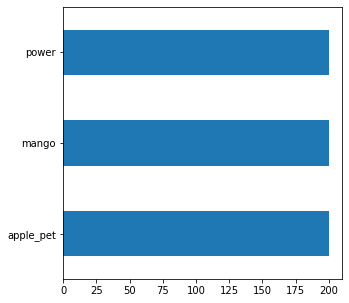

In [4]:
plt.figure(figsize=(5,5))
img_df['label'].value_counts().sort_index().plot.barh()

img_df['label'].value_counts().sort_index()

## Augmentation

In [5]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, RandomGamma, VerticalFlip,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue, 
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, Rotate, RandomContrast, RandomBrightness, RandomCrop, Resize, OpticalDistortion
)

In [6]:
transforms = Compose([
        #Rotate(limit=30, p=0.5),
        #Rotate(limit=180, p=0.5),
        #RandomRotate90(p=1.0)
        #Transpose(p=1.0)
        Resize(248,248, p=0.5),     # resize 후 크롭
        RandomCrop(224,224, p=0.5),  # 위에꺼랑 세트
        
        OneOf([
        RandomContrast(p=1, limit=(-0.5,2)),   # -0.5 ~ 2 까지가 현장과 가장 비슷함  -- RandomBrightnessContrast
        RandomBrightness(p=1, limit=(-0.2,0.4)),
        RandomGamma(p=1, gamma_limit=(80,200)),
        ], p=0.6),
            
        OneOf([
            Rotate(limit=30, p=0.3),
            RandomRotate90(p=0.3),
            VerticalFlip(p=0.3)
        ], p=0.3),
    
        MotionBlur(p=0.2),   # 움직일때 흔들리는 것 같은 이미지
        ShiftScaleRotate(shift_limit=0.001, scale_limit=0.1, rotate_limit=30, p=0.3, border_mode=1),
        Resize(224,224, p=1),
        ],
        p=1)

Text(0.5, 1.0, 'transformed - (224, 224, 3)')

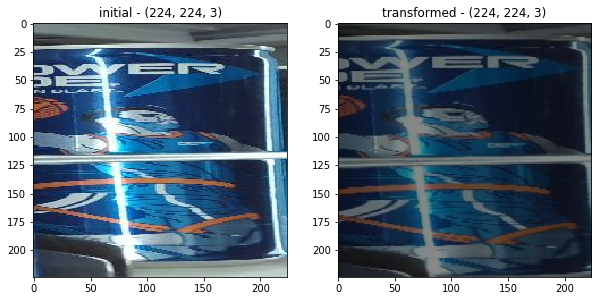

In [34]:
# augmentation option 확인

img = cv2.imread(img_df['image_path'][0])
img = cv2.resize(img,(224,224))
img = cv2.cvtColor(img, cv2.cv2.COLOR_BGR2RGB)
#img = img.reshape((224,224))
img.shape

img1 = transforms(image=img)['image']

f, ax = plt.subplots(1,2,figsize=(10,16))
ax[0].imshow(img)
ax[1].imshow(img1)

ax[0].set_title('initial - {}'.format(img.shape))
ax[1].set_title('transformed - {}'.format(img1.shape))

In [40]:
a = img_df.sample(n=5)['label']

In [103]:
img_df[img_df['label'] == 'power'].sample(n=1)['image_path'].iloc[0]

'../datasets/aug_test_copy/power/0.jpg'

In [206]:
TOTAL_IMG_COUNT = 200

for label in tqdm(label_list):
    #print(label)
    counts = len(img_df[img_df['label'] == f'{label}'])

    while True:
        if counts < TOTAL_IMG_COUNT:
            img_path = img_df[img_df['label'] == f'{label}'].sample(n=1)['image_path'].iloc[0]
            img = cv2.imread(img_path)
            img = cv2.resize(img,(224,224))
            img = cv2.cvtColor(img, cv2.cv2.COLOR_BGR2RGB)
            img = train_transforms(image=img)['image']
            img = cv2.cvtColor(img, cv2.cv2.COLOR_RGB2BGR)
            
            cv2.imwrite(os.path.join(img_dir,label,f'aug_{counts + 1}.jpg'), img)
            counts += 1
            #print(counts)
            #print(os.path.join(img_dir,label,f'aug_{counts + 1}.jpg'),' done!!')
            #print('----------------------------------------------------------------')
        else:
            break

100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


In [207]:
label_cnt = []
for label in label_list:
    label_cnt.append([label, len(glob(os.path.join(img_dir,label,'*')))])

pd.DataFrame(label_cnt, columns=['label', 'counts'])

,label,counts
0,power,200
1,mango,200
2,apple_pet,200
